In [1]:
from bs4 import BeautifulSoup
from IPython.core.display import display, HTML
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from datetime import datetime as dt
from datetime import date as dt1
import time, os
import requests
import re
import pandas as pd

chromedriver = "/Applications/chromedriver"
os.environ["webdriver.chrome.driver"] = chromedriver


In [2]:
# Get table from boxofficereport.com/trailerviews/highesttrailerviews.html and convert into a dataframe
# as well as debug some values.

dfs = pd.read_html('http://www.boxofficereport.com/trailerviews/highesttrailerviews.html', header = 0)
df = dfs[4]
df['Film (Distributor)'] = df['Film (Distributor)'].str.split('(', 1).map(lambda x: x[0])
df.rename(columns={'Film (Distributor)':'Title'}, inplace=True)
df['ReleaseDate'] = pd.to_datetime(df['ReleaseDate'])
df['Domestic']= ''
df['International']= ''
df['Worldwide']= ''
bugged = df.index[df['Title'] == 'Rambo: Last Blood']
df.at[bugged[0], 'ReleaseDate'] = pd.to_datetime('2019-09-20')
df.drop('TrailerLink', axis = 1, inplace = True)
df

,Title,ReleaseDate,OW to YTRatio,OpeningWeekend,YT TrailerViews,Domestic,International,Worldwide
0,Avengers: Infinity War,2018-04-27,1.058,$257.698 M,243.509 M,,,
1,Avengers: Endgame,2019-04-26,1.530,$357.115 M,233.372 M,,,
2,Incredibles 2,2018-06-15,1.144,$182.688 M,159.730 M,,,
3,Frozen II,2019-11-22,0.846,$130.263 M,154.065 M,,,
4,Venom,2018-10-05,0.587,$80.256 M,136.678 M,,,
...,...,...,...,...,...,...,...,...
123,Bad Times at the El Royale,2018-10-12,0.340,$7.133 M,20.953 M,,,
124,Murder on the Orient Express,2017-11-10,1.399,$28.681 M,20.501 M,,,
125,Queen & Slim,2019-11-27,0.584,$11.890 M,20.352 M,,,
126,Unfriended: Dark Web,2018-07-20,0.181,$3.653 M,20.136 M,,,


In [3]:
# Scrub boxofficemojo.com for domestic, international, and worldwide box office revenues and put them into 
# the dataframe. Remove movies from dataframe that havent been released yet and thus have no values for
# box office revenue.

mojo_search = 'https://www.boxofficemojo.com/search/?q='
driver = webdriver.Chrome(chromedriver)
not_yet_released = ['Sonic the Hedgehog', 'Top Gun: Maverick', 'Mulan', 'Black Widow', 'Scoob!', 'Trolls World Tour', 'Bad Boys for Life', 'Birds of Prey', 'Wonder Woman 1984', 'Gretel & Hansel', 'Dolittle', 'A Quiet Place Part II']
today = dt1.today()

for index, row in df.iterrows():
    if(row['ReleaseDate'] < today):
        query = row['Title']
        mojo_query = mojo_search + query.replace(' ', '+').replace(':', '%3A').replace('&', '%26')
        driver.get(mojo_query)
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        links = driver.find_elements_by_xpath("//a[@class='a-size-medium a-link-normal a-text-bold']")
        results = []
        
        for link in links:
            href = link.get_attribute('href')
            results.append(href)
            
        url = results[0]
        response = requests.get(url)
        page = response.text
        movie_soup = BeautifulSoup(page, "lxml")
        box_office = movie_soup.find(class_='mojo-performance-summary-table').find_all('span', class_='money')
        df.at[index, 'Domestic'] = box_office[0].text
        df.at[index, 'International'] = box_office[1].text
        df.at[index, 'Worldwide'] = box_office[2].text

not_released = df[df.ReleaseDate > today]
df = df[df.ReleaseDate < today]
df

/Users/rowem5/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
/Users/rowem5/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.


,Title,ReleaseDate,OW to YTRatio,OpeningWeekend,YT TrailerViews,Domestic,International,Worldwide
0,Avengers: Infinity War,2018-04-27,1.058,$257.698 M,243.509 M,"$678,815,482","$1,369,544,272","$2,048,359,754"
1,Avengers: Endgame,2019-04-26,1.530,$357.115 M,233.372 M,"$858,373,000","$1,939,427,564","$2,797,800,564"
2,Incredibles 2,2018-06-15,1.144,$182.688 M,159.730 M,"$608,581,744","$634,223,615","$1,242,805,359"
3,Frozen II,2019-11-22,0.846,$130.263 M,154.065 M,"$467,066,248","$938,725,401","$1,405,791,649"
4,Venom,2018-10-05,0.587,$80.256 M,136.678 M,"$213,515,506","$642,569,645","$856,085,151"
...,...,...,...,...,...,...,...,...
123,Bad Times at the El Royale,2018-10-12,0.340,$7.133 M,20.953 M,"$17,839,115","$14,043,609","$31,882,724"
124,Murder on the Orient Express,2017-11-10,1.399,$28.681 M,20.501 M,"$102,826,543","$249,963,268","$352,789,811"
125,Queen & Slim,2019-11-27,0.584,$11.890 M,20.352 M,"$43,745,645","$400,000","$44,145,645"
126,Unfriended: Dark Web,2018-07-20,0.181,$3.653 M,20.136 M,"$8,866,745","$7,158,242","$16,024,987"


In [4]:
df_copy = df.copy()
df= df.dropna()
df

,Title,ReleaseDate,OW to YTRatio,OpeningWeekend,YT TrailerViews,Domestic,International,Worldwide
0,Avengers: Infinity War,2018-04-27,1.058,$257.698 M,243.509 M,"$678,815,482","$1,369,544,272","$2,048,359,754"
1,Avengers: Endgame,2019-04-26,1.530,$357.115 M,233.372 M,"$858,373,000","$1,939,427,564","$2,797,800,564"
2,Incredibles 2,2018-06-15,1.144,$182.688 M,159.730 M,"$608,581,744","$634,223,615","$1,242,805,359"
3,Frozen II,2019-11-22,0.846,$130.263 M,154.065 M,"$467,066,248","$938,725,401","$1,405,791,649"
4,Venom,2018-10-05,0.587,$80.256 M,136.678 M,"$213,515,506","$642,569,645","$856,085,151"
...,...,...,...,...,...,...,...,...
123,Bad Times at the El Royale,2018-10-12,0.340,$7.133 M,20.953 M,"$17,839,115","$14,043,609","$31,882,724"
124,Murder on the Orient Express,2017-11-10,1.399,$28.681 M,20.501 M,"$102,826,543","$249,963,268","$352,789,811"
125,Queen & Slim,2019-11-27,0.584,$11.890 M,20.352 M,"$43,745,645","$400,000","$44,145,645"
126,Unfriended: Dark Web,2018-07-20,0.181,$3.653 M,20.136 M,"$8,866,745","$7,158,242","$16,024,987"


In [5]:
# Convert appropriate columns to integers for analysis.

#df = df_copy.copy()
df['OpeningWeekend'] = df['OpeningWeekend'].str.split('$', 1).map(lambda x: x[1]).str.split(' ', 1).map(lambda x: x[0]).str.replace('.', '') + '000'
df['YT TrailerViews'] = df['YT TrailerViews'].str.split(' ', 1).map(lambda x: x[0]).str.replace('.', '') + '000'
df['Domestic'] = df['Domestic'].str.split('$', 1).map(lambda x: x[1]).str.replace(',', '')
df['International'] = df['International'].str.split('$', 1).map(lambda x: x[1]).str.replace(',', '')
df['Worldwide'] = df['Worldwide'].str.split('$', 1).map(lambda x: x[1]).str.replace(',', '')
df[['OpeningWeekend', 'YT TrailerViews', 'Domestic', 'International', 'Worldwide']] = df[['OpeningWeekend', 'YT TrailerViews', 'Domestic', 'International', 'Worldwide']].astype(int)
df

,Title,ReleaseDate,OW to YTRatio,OpeningWeekend,YT TrailerViews,Domestic,International,Worldwide
0,Avengers: Infinity War,2018-04-27,1.058,257698000,243509000,678815482,1369544272,2048359754
1,Avengers: Endgame,2019-04-26,1.530,357115000,233372000,858373000,1939427564,2797800564
2,Incredibles 2,2018-06-15,1.144,182688000,159730000,608581744,634223615,1242805359
3,Frozen II,2019-11-22,0.846,130263000,154065000,467066248,938725401,1405791649
4,Venom,2018-10-05,0.587,80256000,136678000,213515506,642569645,856085151
...,...,...,...,...,...,...,...,...
123,Bad Times at the El Royale,2018-10-12,0.340,7133000,20953000,17839115,14043609,31882724
124,Murder on the Orient Express,2017-11-10,1.399,28681000,20501000,102826543,249963268,352789811
125,Queen & Slim,2019-11-27,0.584,11890000,20352000,43745645,400000,44145645
126,Unfriended: Dark Web,2018-07-20,0.181,3653000,20136000,8866745,7158242,16024987


In [68]:
#create a new df to build model off of

numbers = df[['YT TrailerViews', 'OpeningWeekend', 'Domestic', 'International', 'Worldwide']].copy()
numbers = numbers.dropna()
numbers = numbers.astype('int64')
numbers.mean(axis = 0)

YT TrailerViews    5.209330e+07
OpeningWeekend     5.804792e+07
Domestic           1.752315e+08
International      3.197588e+08
Worldwide          4.949903e+08
dtype: float64

In [7]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
%matplotlib inline

In [8]:
numbers = numbers.drop(['Worldwide'], axis = 1)
numbers

,YT TrailerViews,OpeningWeekend,Domestic,International
0,243509000,257698000,678815482,1369544272
1,233372000,357115000,858373000,1939427564
2,159730000,182688000,608581744,634223615
3,154065000,130263000,467066248,938725401
4,136678000,80256000,213515506,642569645
...,...,...,...,...
123,20953000,7133000,17839115,14043609
124,20501000,28681000,102826543,249963268
125,20352000,11890000,43745645,400000
126,20136000,3653000,8866745,7158242


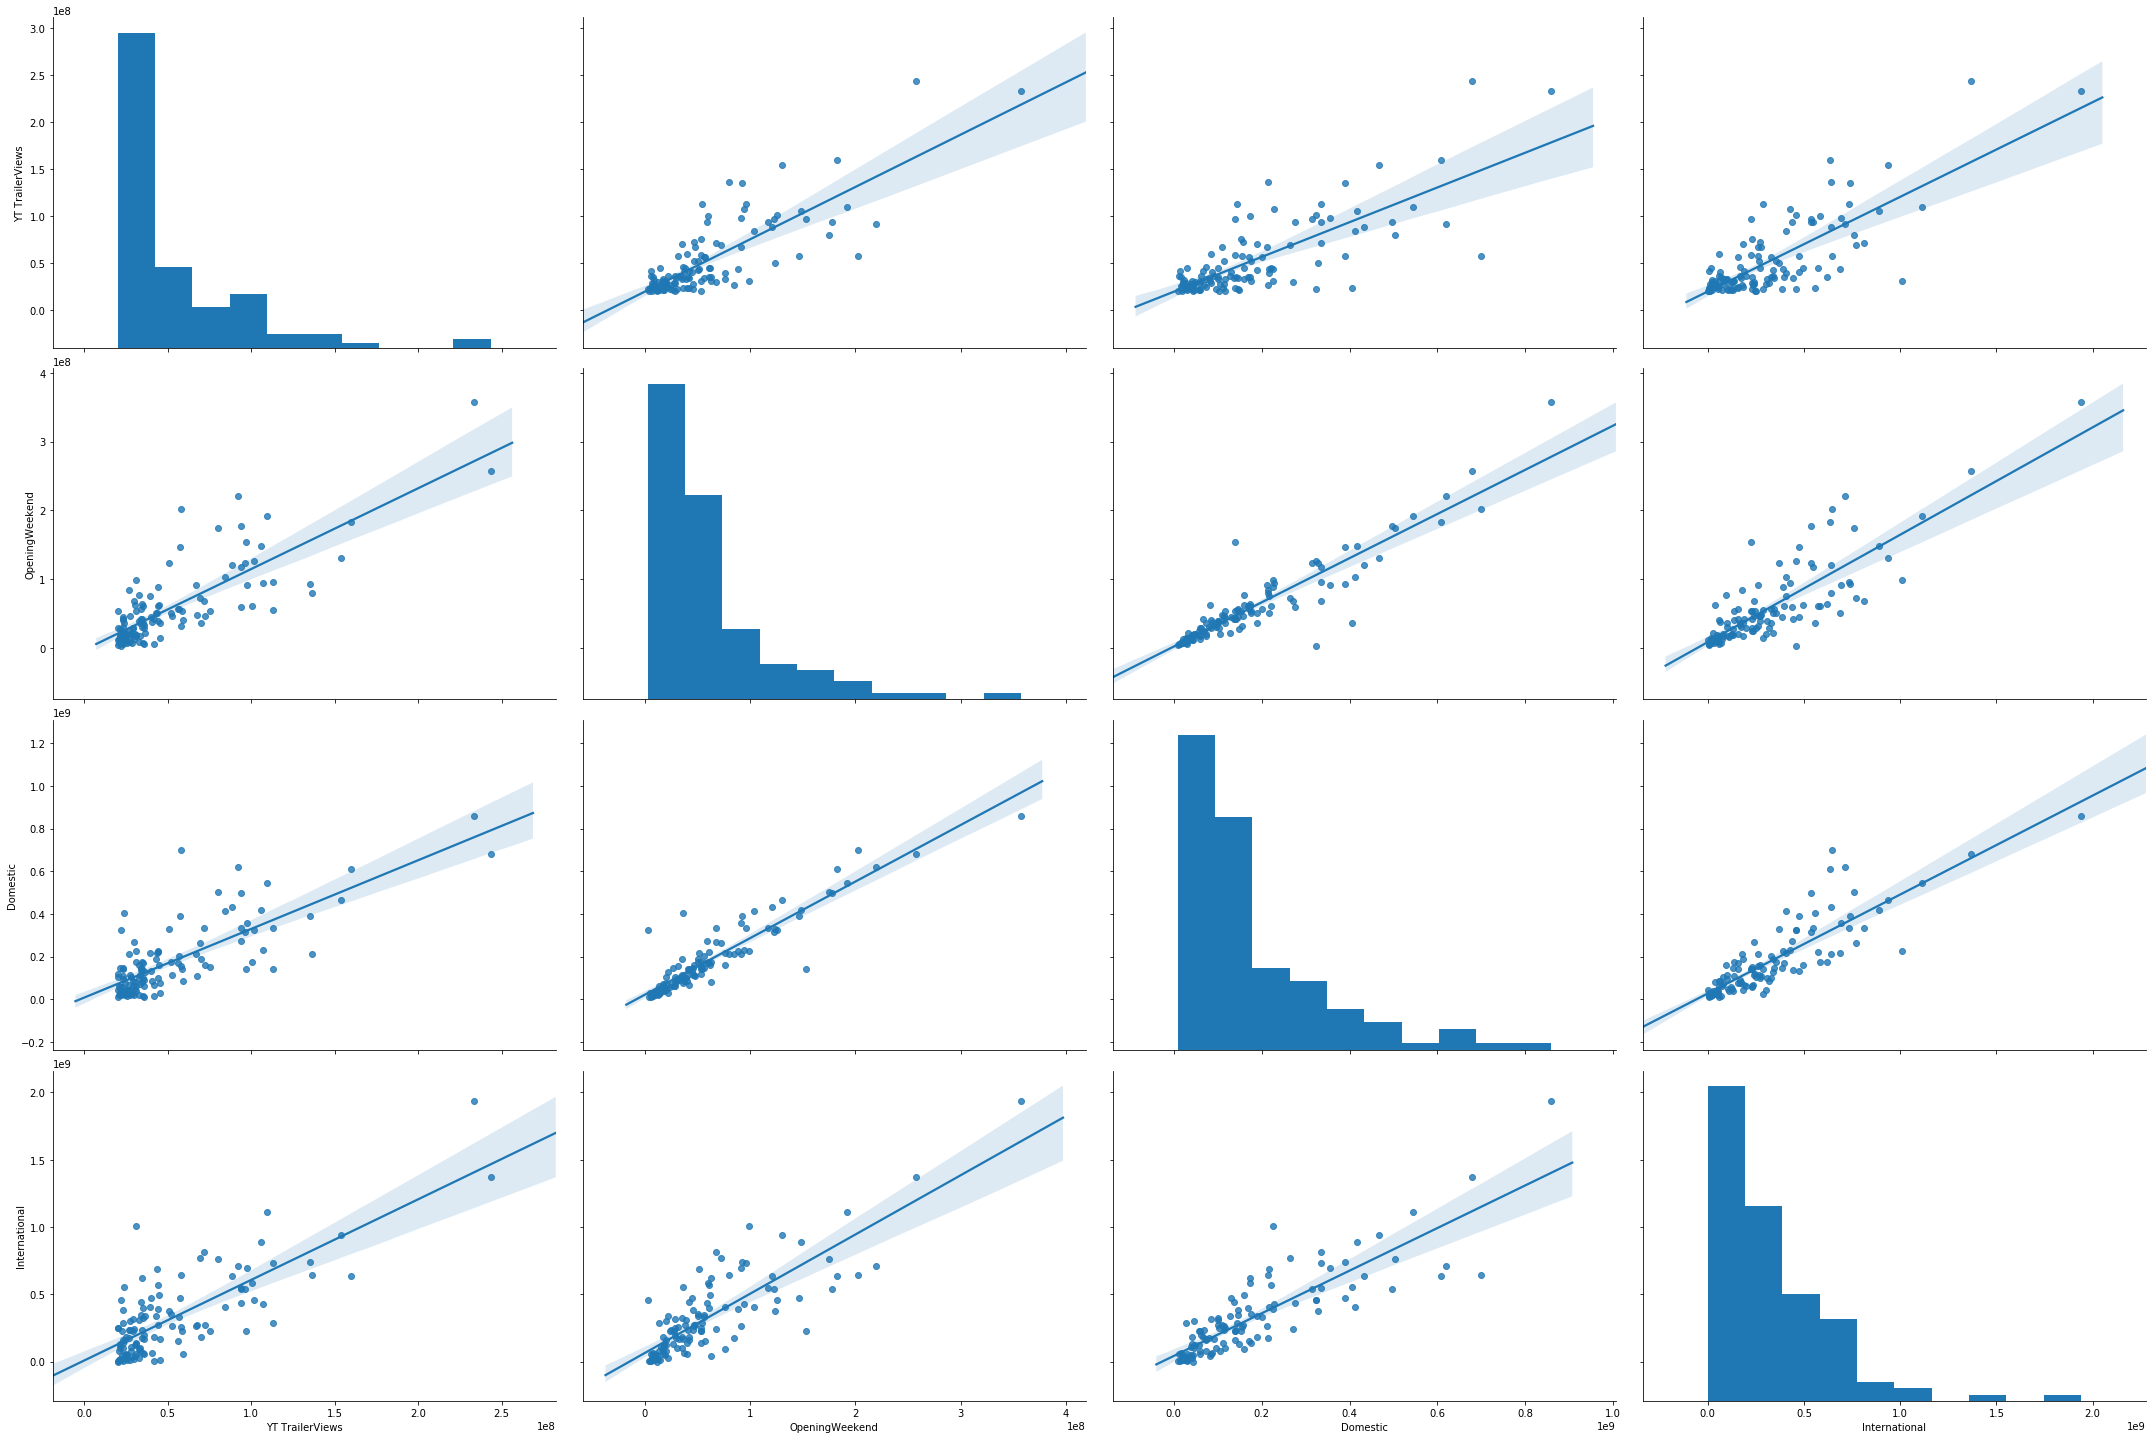

In [9]:
sns.pairplot(numbers, kind = 'reg', height=5, aspect=1.5);
sns.set_context("paper", rc={"axes.labelsize":40})

In [10]:
#get initial linear regression score
lr = LinearRegression()
X = numbers.iloc[:, 1:]
y = numbers.iloc[:, 0]
lr.fit(X, y)
lr.score(X,y)


0.6910472543269384

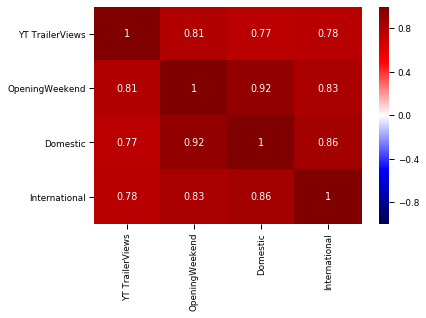

In [47]:
sns.heatmap(numbers.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

In [12]:
lsm = sm.OLS(y, X)
fit = lsm.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:        YT TrailerViews   R-squared (uncentered):                   0.855
Model:                            OLS   Adj. R-squared (uncentered):              0.851
Method:                 Least Squares   F-statistic:                              226.0
Date:                Fri, 24 Jan 2020   Prob (F-statistic):                    4.79e-48
Time:                        02:51:11   Log-Likelihood:                         -2177.3
No. Observations:                 118   AIC:                                      4361.
Df Residuals:                     115   BIC:                                      4369.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
OpeningWeekend     0.3979      0.107      3.735      0.000       0.187       0.609
Domestic           0.0135      0.040      0.340      0.735      -0.065       0.093
International      0.0588      0.015      3.983      0.000       0.030       0.088
==============================================================================
Omnibus:                        9.899   Durbin-Watson:                   1.593
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               12.074
Skew:                          -0.490   Prob(JB):                      0.00239
Kurtosis:                       4.223   Cond. No.                         24.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    print('\nValidation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}') 

In [14]:
split_and_validate(X, y)


Validation R^2 score was: 0.6818520470533357
Feature coefficient results: 

OpeningWeekend : 0.30
Domestic : -0.01
International : 0.05


In [15]:
#feature engineering: creating a logarithmic conversion of dependent variables
X2 = X.copy()

X2['OpeningWeekend_log'] = np.log(X2['OpeningWeekend'])
X2['Domestic_log'] = np.log(X2['Domestic'])
X2['International_log'] = np.log(X2['International'])


split_and_validate(X2, y)


Validation R^2 score was: 0.6709923436698835
Feature coefficient results: 

OpeningWeekend : 0.09
Domestic : 0.05
International : 0.07
OpeningWeekend_log : 11448539.76
Domestic_log : -8441691.42
International_log : -4525696.34


In [17]:
import scipy.stats as stats
model = sm.OLS(y,X)
fit = model.fit()
fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:        YT TrailerViews   R-squared (uncentered):                   0.855
Model:                            OLS   Adj. R-squared (uncentered):              0.851
Method:                 Least Squares   F-statistic:                              226.0
Date:                Fri, 24 Jan 2020   Prob (F-statistic):                    4.79e-48
Time:                        02:51:11   Log-Likelihood:                         -2177.3
No. Observations:                 118   AIC:                                      4361.
Df Residuals:                     115   BIC:                                      4369.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
OpeningWeekend     0.3979      0.107      3.735      0.000       0.187       0.609
Domestic           0.0135      0.040      0.340      0.735      -0.065       0.093
International      0.0588      0.015      3.983      0.000       0.030       0.088
==============================================================================
Omnibus:                        9.899   Durbin-Watson:                   1.593
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               12.074
Skew:                          -0.490   Prob(JB):                      0.00239
Kurtosis:                       4.223   Cond. No.                         24.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'Ordered Values')

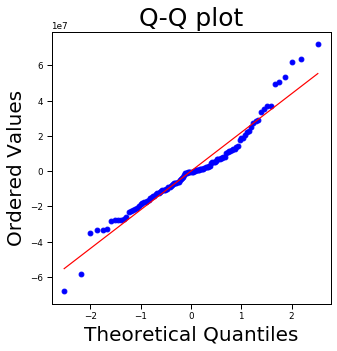

In [64]:
# QQ plot
rgr = LinearRegression()
rgr.fit(X,y)
pred = rgr.predict(X)
res = y - pred

plt.figure(figsize = (5, 5))
stats.probplot(res, dist="norm", plot=plt)
plt.title("Q-Q plot", fontsize = 25)
plt.xlabel("Theoretical Quantiles", fontsize = 20)
plt.ylabel("Ordered Values", fontsize = 20 )

In [19]:
#cross validation and Ridge model with alpha = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=10)
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=.2, random_state=3)
lm = LinearRegression()
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

lm_reg = Ridge(alpha=1)
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

lm_poly = LinearRegression()

In [20]:
lm.fit(X_train, y_train)
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')

lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')

Linear Regression val R^2: 0.572
Ridge Regression val R^2: 0.572
Degree 2 polynomial regression val R^2: 0.520


In [21]:
lm.fit(X_train,y_train)
print(f'Linear Regression test R^2: {lm.score(X_test, y_test):.3f}')

Linear Regression test R^2: 0.846


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=10)
X, y = np.array(X), np.array(y)

In [23]:

kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_r2s, cv_lm_reg_r2s = [], [] 

for train_ind, val_ind in kf.split(X,y):
    
    X_tr, y_tr = X[train_ind], y[train_ind]
    X_te, y_te = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()
    lm_reg = Ridge(alpha=1)

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val))
    
    #ridge with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))

print('Simple regression scores: ', cv_lm_r2s)
print('Ridge scores: ', cv_lm_reg_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')

Simple regression scores:  [0.5718090639802762, 0.5718090639802762, 0.5718090639802762, 0.5718090639802762, 0.5718090639802762]
Ridge scores:  [0.572307321935819, 0.572307321935819, 0.572307321935819, 0.572307321935819, 0.572307321935819] 

Simple mean cv r^2: 0.572 +- 0.000
Ridge mean cv r^2: 0.572 +- 0.000


In [24]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

lm_reg = Ridge(alpha=1)
lm_reg.fit(X_scaled,y)
print(f'Ridge Regression test R^2: {lm_reg.score(X_test_scaled, y_test):.3f}')

Ridge Regression test R^2: 0.864


In [25]:
selected_columns= ['OpeningWeekend', 'Domestic', 'International']
test_set_pred = lm_reg.predict(X_test.loc[:,selected_columns])
# X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

# lasso_model = Lasso(alpha = 10000) 
# lasso_model.fit(X_train.loc[:,selected_columns], y_train)

In [26]:
#list(zip(selected_columns, lasso_model.coef_))

In [27]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 
mae(y_test, test_set_pred)

5859180846975464.0

In [28]:
alphalist = 10**(np.linspace(-2,2,200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('standardize', StandardScaler()), 
             ('ridge', Ridge(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train.loc[:,selected_columns].values, y_train)
    
    val_set_pred = pipe.predict(X_val.loc[:,selected_columns].values)
    err_vec_val[i] = mae(y_val, val_set_pred)

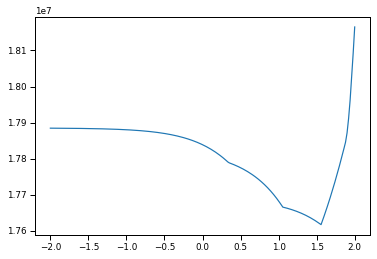

In [29]:
plt.plot(np.log10(alphalist), err_vec_val)

In [30]:
np.min(err_vec_val)

17616820.47920708

In [31]:
alphalist[np.argmin(err_vec_val)]

36.123426997094306

In [32]:
std = StandardScaler()
std.fit(X_train.values)

X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)

alphavec = 10**np.linspace(-2,2,200)

ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_tr, y_train)

/Users/rowem5/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RidgeCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
        store_cv_values=False)

In [45]:
ridge_model.alpha_


0.01

In [34]:
list(zip(X_train.columns, ridge_model.coef_))

[('OpeningWeekend', 22302116.12595133),
 ('Domestic', -6241997.727188373),
 ('International', 14835111.45408821)]

In [43]:
test_set_pred = ridge_model.predict(X_te)


array([6.74872504e+07, 2.18542588e+07, 3.59954703e+07, 3.93690645e+07,
       1.74984601e+07, 2.20255785e+07, 1.96967377e+07, 2.83867326e+07,
       1.84081059e+07, 1.07019360e+08, 3.87516108e+07, 6.29277193e+07,
       2.72984139e+07, 4.37798751e+07, 4.24184641e+07, 2.44996691e+08,
       1.13038534e+08, 5.06030726e+07, 4.89765962e+07, 3.40134150e+07,
       4.88999359e+07, 2.49899665e+07, 4.65672717e+07, 1.27509579e+08])

In [36]:
r2_score(y_test, test_set_pred)

0.84607404237481

In [37]:
mae(y_test, test_set_pred)

13857375.857189057

In [69]:
from sklearn.linear_model import lars_path

In [70]:
std = StandardScaler()
std.fit(X_train.values)
X_tr = std.transform(X_train.values)

In [71]:
print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_tr, y_train.values, method='lasso')

Computing regularization path using the LARS ...


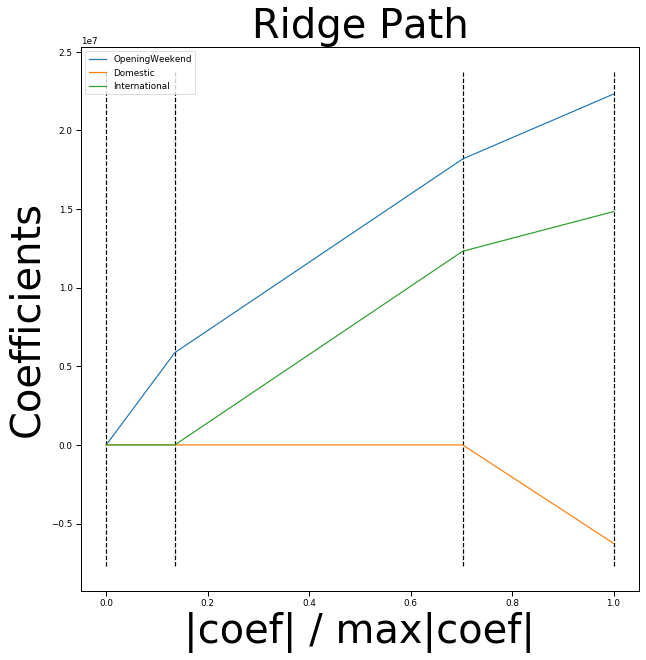

In [72]:
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('Ridge Path', fontsize = 40)
plt.axis('tight')
plt.legend(X_train.columns)
plt.show()

In [51]:
model = sm.OLS(y,X)
fit = model.fit()
fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.855
Model:                            OLS   Adj. R-squared (uncentered):              0.851
Method:                 Least Squares   F-statistic:                              226.0
Date:                Fri, 24 Jan 2020   Prob (F-statistic):                    4.79e-48
Time:                        03:46:53   Log-Likelihood:                         -2177.3
No. Observations:                 118   AIC:                                      4361.
Df Residuals:                     115   BIC:                                      4369.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3979      0.107      3.735      0.000       0.187       0.609
x2             0.0135      0.040      0.340      0.735      -0.065       0.093
x3             0.0588      0.015      3.983      0.000       0.030       0.088
==============================================================================
Omnibus:                        9.899   Durbin-Watson:                   1.593
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               12.074
Skew:                          -0.490   Prob(JB):                      0.00239
Kurtosis:                       4.223   Cond. No.                         24.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

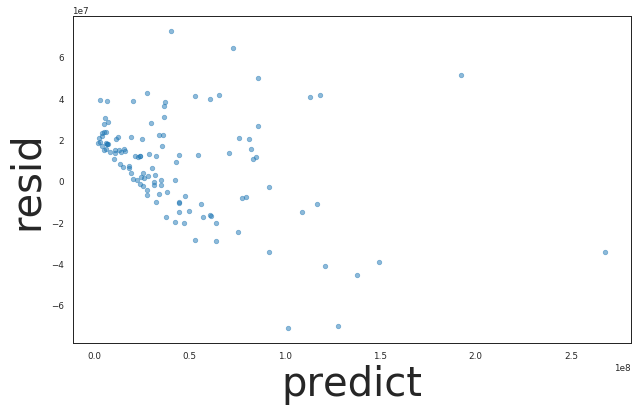

In [56]:
# create residual plot
numbers['predict']=fit.predict(X)
numbers['resid']= y-numbers.predict
with sns.axes_style('white'):
    plot = numbers.plot(
        kind='scatter', x='predict', y='resid', alpha=0.5, figsize=(10,6))

Text(0, 0.5, 'residuals')

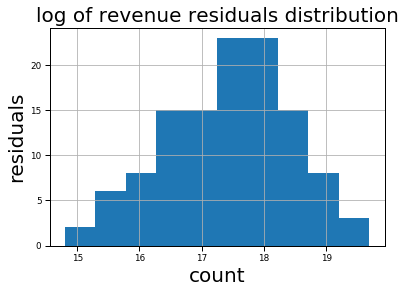

In [61]:
np.log(numbers.OpeningWeekend).hist();
plt.title('log of revenue residuals distribution', fontsize = 20)
plt.xlabel('count', fontsize = 20)
plt.ylabel('residuals', fontsize = 20)

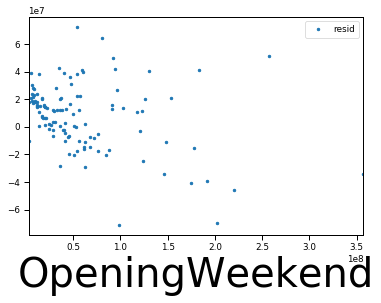

In [62]:
ts = numbers[['OpeningWeekend','resid']].set_index('OpeningWeekend')
ts.plot(style=".");